# Comparison of Methods for Finding the Optimal Number of Clusters

# Elbow Method vs. Silhouette Method vs. Gap Statistic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to implement the Gap Statistic method
def gap_statistic(data, k_max=10, n_refs=5, random_seed=42):
    """
    Compute the Gap statistic for estimating the optimal number of clusters.
    
    Parameters:
    -----------
    data : array-like
        Input data
    k_max : int, optional (default=10)
        Maximum number of clusters to consider
    n_refs : int, optional (default=5)
        Number of reference datasets to generate
    random_seed : int, optional (default=42)
        Random seed for reproducibility
        
    Returns:
    --------
    gap_df : pandas.DataFrame
        DataFrame containing the gap statistic, standard error, and related values
    """
    # Generate reference data sets
    np.random.seed(random_seed)
    
    # Array to hold gap statistics
    gaps = np.zeros(k_max)
    stds = np.zeros(k_max)
    
    # Sample size and feature dimension from input data
    n_samples, n_features = data.shape
    
    # Compute min/max for each feature to define bounds for reference data
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    # Compute the dispersion for each k for real data
    dispersion_real = np.zeros(k_max)
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_seed, n_init=10)
        kmeans.fit(data)
        dispersion_real[k-1] = np.sum(np.square(kmeans.inertia_))
    
    # For each k, compute the dispersion for n_refs reference datasets
    for k in range(1, k_max + 1):
        ref_dispersions = np.zeros(n_refs)
        
        for i in range(n_refs):
            # Create random reference data within the same bounds as original data
            ref_data = np.random.random_sample((n_samples, n_features))
            
            # Scale the random data to match the range of the original data
            for j in range(n_features):
                ref_data[:, j] = min_vals[j] + ref_data[:, j] * (max_vals[j] - min_vals[j])
            
            # Cluster the reference data
            kmeans = KMeans(n_clusters=k, random_state=random_seed, n_init=10)
            kmeans.fit(ref_data)
            
            # Compute dispersion
            ref_dispersions[i] = np.sum(np.square(kmeans.inertia_))
        
        # Calculate the gap statistic and standard error
        gap = np.mean(np.log(ref_dispersions)) - np.log(dispersion_real[k-1])
        sd = np.std(np.log(ref_dispersions)) * np.sqrt(1 + 1/n_refs)
        
        gaps[k-1] = gap
        stds[k-1] = sd
    
    # Compute the optimal k using the 1-standard-error rule
    k_values = np.arange(1, k_max + 1)
    gap_criterion = gaps - np.roll(gaps, -1) + stds
    optimal_k = k_values[np.argmax(gap_criterion[:-1])]
    
    # Create a DataFrame with the results
    gap_df = pd.DataFrame({
        'k': k_values,
        'gap': gaps,
        'std_error': stds,
        'gap_criterion': np.append(gap_criterion[:-1], np.nan)
    })
    
    return gap_df, optimal_k

In [4]:
# Load and prepare the data
df = pd.read_csv('Datasets/mall.csv')
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

In [5]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up the k range and initialize lists to store results
k_range = range(1, 11)
inertia_values = []
silhouette_values = []

In [6]:
# Calculate inertia and silhouette score for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)
    
    # Silhouette score requires at least 2 clusters
    if k > 1:
        silhouette_values.append(silhouette_score(X_scaled, kmeans.labels_))
    else:
        silhouette_values.append(0)  # placeholder for k=1

# Calculate Gap Statistic
gap_df, optimal_k_gap = gap_statistic(X_scaled, k_max=10, n_refs=5)

# Find optimal k using Elbow Method (using second derivative)
def find_elbow_point(inertia_values):
    # Calculate first difference
    first_diff = np.diff(inertia_values)
    # Calculate second difference (change in the rate of decline)
    second_diff = np.diff(first_diff)
    # Find the index where the second difference is maximized
    elbow_index = np.argmax(second_diff) + 2  # +2 because of double differencing
    return elbow_index + 1  # +1 because k starts at 1

# Find optimal k using Silhouette Method
optimal_k_silhouette = np.argmax(silhouette_values) + 1  # +1 because indices start at 0

# Find optimal k using Elbow Method
optimal_k_elbow = find_elbow_point(inertia_values)

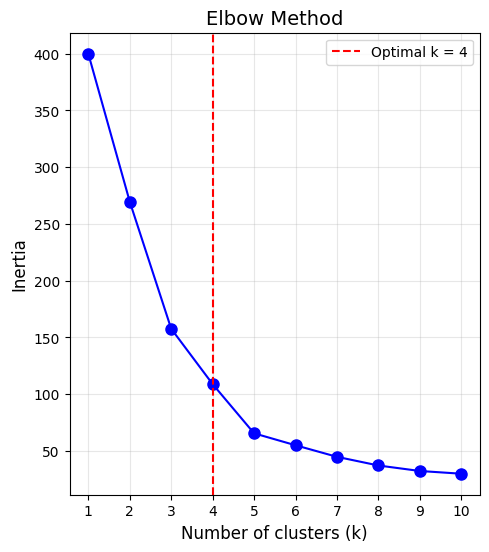

In [7]:
# Visualization of all three methods
plt.figure(figsize=(18, 6))

# 1. Elbow Method
plt.subplot(1, 3, 1)
plt.plot(k_range, inertia_values, 'bo-', markersize=8)
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', 
            label=f'Optimal k = {optimal_k_elbow}')
plt.title('Elbow Method', fontsize=14)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.legend()

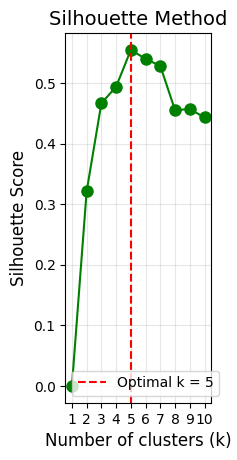

In [8]:
# 2. Silhouette Method
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_values, 'go-', markersize=8)
plt.axvline(x=optimal_k_silhouette, color='r', linestyle='--', 
            label=f'Optimal k = {optimal_k_silhouette}')
plt.title('Silhouette Method', fontsize=14)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.legend()

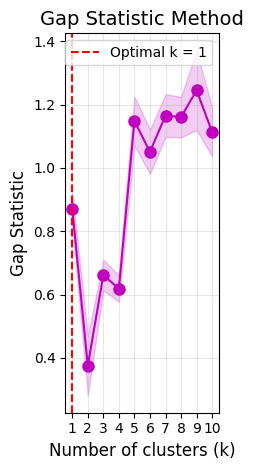

In [9]:
# 3. Gap Statistic Method
plt.subplot(1, 3, 3)
plt.plot(gap_df['k'], gap_df['gap'], 'mo-', markersize=8)
plt.fill_between(gap_df['k'], 
                 gap_df['gap'] - gap_df['std_error'],
                 gap_df['gap'] + gap_df['std_error'], 
                 alpha=0.2, color='m')
plt.axvline(x=optimal_k_gap, color='r', linestyle='--', 
            label=f'Optimal k = {optimal_k_gap}')
plt.title('Gap Statistic Method', fontsize=14)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Gap Statistic', fontsize=12)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Create clusters using each optimal k value and visualize
def create_and_plot_clusters(X, k, method_name):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', 
                marker='X', s=200, label='Centroids')
    plt.title(f'K-means Clustering with k={k} ({method_name})', fontsize=14)
    plt.xlabel('Annual Income (k$)', fontsize=12)
    plt.ylabel('Spending Score (1-100)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # Return silhouette score for comparison
    return silhouette_score(X, labels) if k > 1 else 0

In [11]:
# Create a comparison of the three methods
methods = ['Elbow Method', 'Silhouette Method', 'Gap Statistic']
optimal_ks = [optimal_k_elbow, optimal_k_silhouette, optimal_k_gap]

print("Optimal number of clusters comparison:")
print(f"Elbow Method: {optimal_k_elbow}")
print(f"Silhouette Method: {optimal_k_silhouette}")
print(f"Gap Statistic: {optimal_k_gap}")
print("\n")

Optimal number of clusters comparison:
Elbow Method: 4
Silhouette Method: 5
Gap Statistic: 1




Creating clusters using Elbow Method (k=4)...


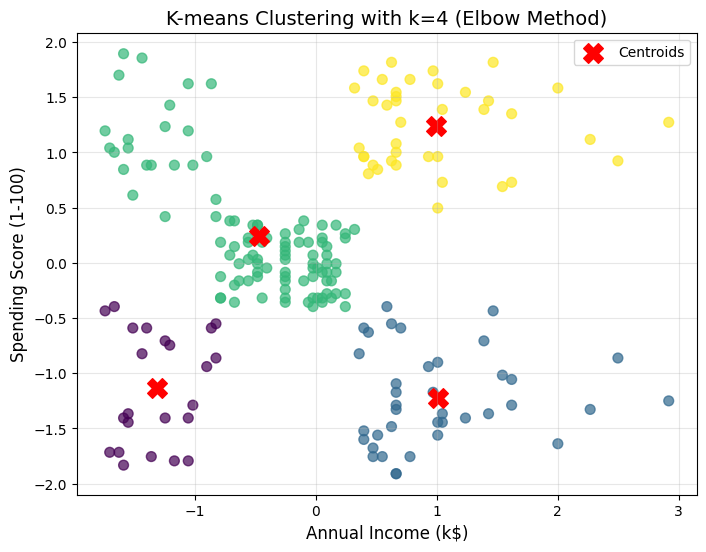

Silhouette score for Elbow Method (k=4): 0.4939
--------------------------------------------------
Creating clusters using Silhouette Method (k=5)...


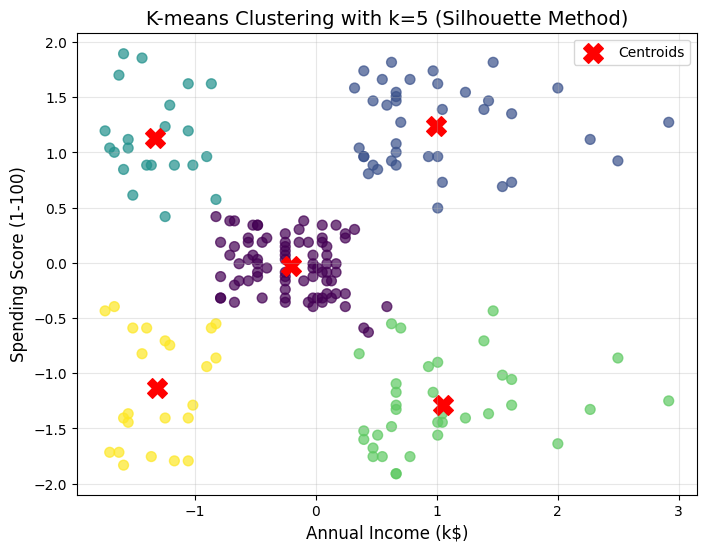

Silhouette score for Silhouette Method (k=5): 0.5547
--------------------------------------------------
Creating clusters using Gap Statistic (k=1)...


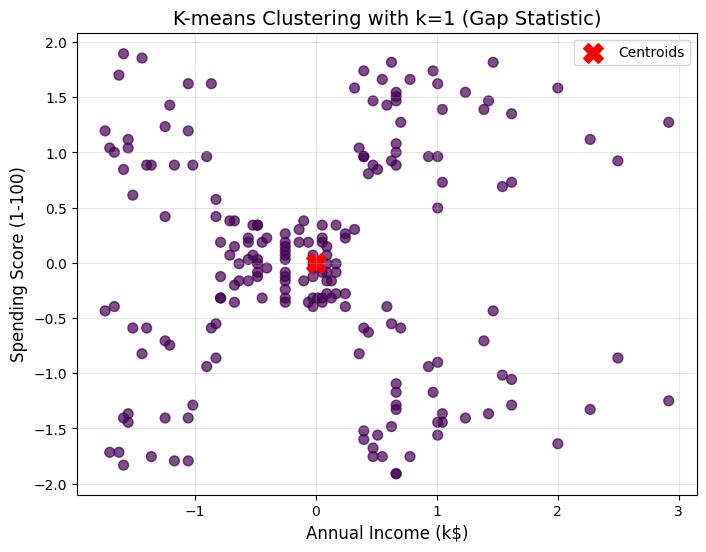

Silhouette score for Gap Statistic (k=1): 0.0000
--------------------------------------------------

Comparison of Methods:


,Method,Optimal k,Silhouette Score,Description,Advantages,Disadvantages
0,Elbow Method,4,0.493907,Plots inertia vs. number of clusters and looks...,"Simple, intuitive, and computationally efficient","Subjective interpretation, less effective when..."
1,Silhouette Method,5,0.554657,Measures how similar an object is to its own c...,Provides a quantitative measure of cluster qua...,Can be misleading for non-globular clusters or...
2,Gap Statistic,1,0.000000,Compares the total within-cluster variation wi...,Statistical approach that can find true k even...,Computationally expensive and may struggle wit...


In [12]:
# Evaluate each method based on its optimal k
silhouette_scores = []
for i, (method, k) in enumerate(zip(methods, optimal_ks)):
    print(f"Creating clusters using {method} (k={k})...")
    score = create_and_plot_clusters(X_scaled, k, method)
    silhouette_scores.append(score)
    print(f"Silhouette score for {method} (k={k}): {score:.4f}")
    print("-" * 50)

# Create a comparison table
comparison_df = pd.DataFrame({
    'Method': methods,
    'Optimal k': optimal_ks,
    'Silhouette Score': silhouette_scores
})

# Add descriptions
comparison_df['Description'] = [
    'Plots inertia vs. number of clusters and looks for the "elbow" point where diminishing returns begin',
    'Measures how similar an object is to its own cluster compared to other clusters',
    'Compares the total within-cluster variation with expected values under a null reference distribution'
]

comparison_df['Advantages'] = [
    'Simple, intuitive, and computationally efficient',
    'Provides a quantitative measure of cluster quality and works well for compact, well-separated clusters',
    'Statistical approach that can find true k even when clusters aren\'t visually apparent'
]

comparison_df['Disadvantages'] = [
    'Subjective interpretation, less effective when clusters overlap or have varied densities',
    'Can be misleading for non-globular clusters or when clusters have very different sizes',
    'Computationally expensive and may struggle with high-dimensional data'
]

print("\nComparison of Methods:")
display(comparison_df)

In [13]:
# Overall recommendation
best_method_index = np.argmax(silhouette_scores)
best_method = methods[best_method_index]
best_k = optimal_ks[best_method_index]

print("\nRecommendation:")
print(f"Based on the highest silhouette score, the {best_method} with k={best_k} provides the best clustering.")
print("However, the final choice should consider the data characteristics and business requirements.")

# Check for agreement between methods
if len(set(optimal_ks)) == 1:
    print("\nAll three methods agree on the optimal number of clusters!")
else:
    print("\nThe methods suggest different optimal numbers of clusters.")
    print("This is common and reflects different perspectives on what constitutes 'optimal' clustering.")
    print("Consider the specific characteristics of your data and the business context.")


Recommendation:
Based on the highest silhouette score, the Silhouette Method with k=5 provides the best clustering.
However, the final choice should consider the data characteristics and business requirements.

The methods suggest different optimal numbers of clusters.
This is common and reflects different perspectives on what constitutes 'optimal' clustering.
Consider the specific characteristics of your data and the business context.
